In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import r2_score

In [407]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_sept.csv", sep=",")

In [408]:
df.dropna(inplace=True)

In [409]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [410]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [411]:
cutoffs = pd.date_range(
    start="2024-09-30",   # first end-of-month
    end="2025-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [412]:
###resultat valg 2025
valg = {
    "Ap": [28.2],
    "Høyre": [14.6],
    "Frp": [23.9],
    "SV": [5.5],
    "Sp": [5.3],
    "KrF": [4.2],
    "Venstre": [3.8],
    "MDG": [4.7],
    "Rødt": [5.3],
#    "Andre": [3.6],
}


###resultat valg 2021
#valg = {
#    "Ap": [26.3],
#    "Høyre": [20.4],
#    "Frp": [11.6],
#    "SV": [7.6],
#    "Sp": [13.5],
#    "KrF": [3.8],
#    "Venstre": [4.6],
#    "MDG": [3.9],
#    "Rødt": [4.7],
##    "Andre": [3.6],
#}

###resultat valg 2017
#valg = {
#    "Ap": [27.4],
#    "Høyre": [25.0],
#    "Frp": [15.2],
#    "SV": [6.0],
#    "Sp": [10.3],
#    "KrF": [4.2],
#    "Venstre": [4.4],
#    "MDG": [3.2],
#    "Rødt": [2.4],
#    "Andre": [1.8],
#}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []
finals = []
y_true = valg_df.values.reshape(1, -1)[0]

In [413]:
parties= ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt']

In [414]:
def granger_select(exog, endog, maxlag=3, p_threshold=0.001, min_variance=1E-06):
    selected = []
    # 1. Drop constant or near-constant columns
    variances = exog.var()
    valid_cols = variances[variances > min_variance].index
    exog = exog[valid_cols]

    for col in exog.columns:
        keep = False
        for target in endog.columns:
            # Combine series and drop NA
            data = pd.concat([endog[target], exog[col]], axis=1).dropna()

            # Skip if we have too few samples
            if len(data) < maxlag + 2:
                continue
            
            try:
                test_result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
                p_values = [res[0]['ssr_ftest'][1] for res in test_result.values()]
                if min(p_values) < p_threshold:
                    keep = True
                    break
            except Exception as e:
                # skip this column if test fails (singular matrix, etc.)
                continue

        if keep:
            selected.append(col)

    return selected


In [415]:
all_party_errors=[]
for i, cutoff in enumerate(cutoffs):
    # Fit model on training set
    df_en=df[parties]

    df_ex = df[[c for c in df.columns if c not in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']]].iloc[1:]

    selected_cols = granger_select(df_ex, df_en, maxlag=3)
    df_ex = df_ex[selected_cols]

    print(selected_cols)
    
    steps = len(cutoffs) - i +1
    

    ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
    df_en=df_en.loc[df_en.index <= cutoff]
    df_ex=df_ex.loc[df_ex.index <= cutoff]

    df_orig=df_en
    df_en_val = df_en.diff().dropna() 
            
    #print(ex_future)
    #print(cutoff)
    model = VAR(df_en_val)
    #model = VAR(endog=df_en_val, exog=df_ex)
    model_fitted = model.fit(maxlags=3, trend='n', method = 'ols')

    forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
            
    last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    #print(last_actual_value)
    #forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
    forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps)
            
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
    forecast_df = forecast_df.cumsum() + last_actual_value
    date_to_extract = "2025-09-30"
    estimate_row = forecast_df.loc[date_to_extract]
    print(estimate_row)
    y_pred = estimate_row.values.reshape(1, -1)[0]  
    #y_pred = (y_pred / y_pred.sum()) * 96
    # Compute per-party errors
    for idx, party in enumerate(parties):
        error_pred = median_absolute_error([y_true[idx]], [y_pred[idx]])
        error_baseline = median_absolute_error([y_true[idx]], [last_actual_value.values[idx]])
        relative_error_pred=error_pred/y_true[idx]
        relative_error_baseline=error_baseline/y_true[idx]
        
        all_party_errors.append({
            "cutoff": cutoff,
            "party": party,
            "steps": steps,
            "last_pop": last_actual_value.values[idx],
            "model_est": y_pred[idx],
            "actual_election_result": y_true[idx],
            "error_forecast": error_pred,
            "error_baseline": error_baseline,
            "relative_error_forecast": relative_error_pred,
            "relative_error_baseline": relative_error_baseline
        })
    

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         19.853055
Hoyre      24.197198
Frp        18.611132
SV          9.072492
SP          6.354464
KrF         3.359520
Venstre     5.193720
MDG         3.535301
Rodt        5.690927
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         19.076790
Hoyre      24.841325
Frp        20.373503
SV          9.168145
SP          4.931107
KrF         3.275817
Venstre     5.461437
MDG         3.131617
Rodt        6.032568
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         19.172225
Hoyre      22.718894
Frp        21.300937
SV          8.997638
SP          6.330395
KrF         3.168813
Venstre     5.258708
MDG         3.218527
Rodt        5.891110
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         17.153651
Hoyre      22.249040
Frp        25.321287
SV          9.280934
SP          5.200208
KrF         3.329545
Venstre     5.377263
MDG         2.712060
Rodt        5.825206
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         18.824413
Hoyre      21.852599
Frp        23.489778
SV          8.260747
SP          6.281423
KrF         3.454293
Venstre     4.906774
MDG         3.455071
Rodt        5.501530
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         24.586138
Hoyre      18.202416
Frp        23.818028
SV          7.498146
SP          6.765032
KrF         3.331073
Venstre     4.309673
MDG         2.823842
Rodt        4.995981
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         26.547715
Hoyre      19.266228
Frp        21.732214
SV          7.719864
SP          5.568489
KrF         3.370170
Venstre     4.351265
MDG         3.029983
Rodt        4.696843
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         28.837562
Hoyre      18.053254
Frp        18.794025
SV          6.717464
SP          7.694011
KrF         3.327655
Venstre     3.992481
MDG         3.769846
Rodt        4.539818
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         28.997656
Hoyre      17.902254
Frp        20.498553
SV          6.661500
SP          6.463166
KrF         3.465792
Venstre     4.045515
MDG         3.215400
Rodt        4.778803
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         28.580758
Hoyre      16.017041
Frp        21.319856
SV          7.018553
SP          5.578034
KrF         3.666783
Venstre     4.566590
MDG         3.127205
Rodt        5.435175
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         27.207671
Hoyre      15.914319
Frp        21.267403
SV          8.224759
SP          6.138134
KrF         3.506920
Venstre     4.734930
MDG         3.019522
Rodt        6.006475
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose

['KrF_skandale_lag3', 'Venstre_reg', 'Ap_reg_lag3', 'Hoyre_reg_lag3', 'KrF_reg_lag3', 'Venstre_reg_lag3', 'Venstre_reg_lag6']
Ap         28.550416
Hoyre      13.476705
Frp        21.392008
SV          6.644636
SP          6.659761
KrF         4.022776
Venstre     4.536483
MDG         4.276772
Rodt        6.032793
Name: 2025-09-30 00:00:00, dtype: float64


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions sh

In [416]:
selected_cols

['KrF_skandale_lag3',
 'Venstre_reg',
 'Ap_reg_lag3',
 'Hoyre_reg_lag3',
 'KrF_reg_lag3',
 'Venstre_reg_lag3',
 'Venstre_reg_lag6']

In [417]:
df_party_errors = pd.DataFrame(all_party_errors)

In [418]:
df_party_errors["better_than_baseline"] = (
    round(df_party_errors["error_forecast"],1) <= round(df_party_errors["error_baseline"],1)
)
df_party_errors["better_than_baseline_relative"] = (
    round(df_party_errors["relative_error_forecast"],1) <= round(df_party_errors["relative_error_baseline"],1)
)

In [419]:
df_party_errors.to_csv('relative.csv')

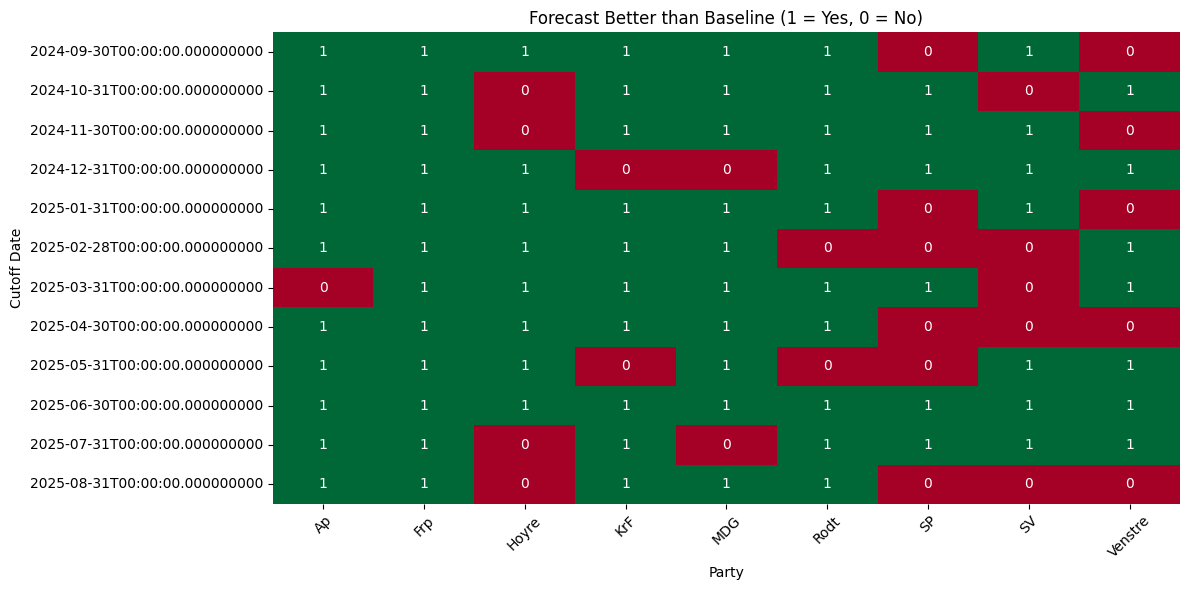

In [420]:
heatmap_data = df_party_errors.pivot(
    index="cutoff", columns="party", values="better_than_baseline_relative"
).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="RdYlGn", cbar=False)
plt.title("Forecast Better than Baseline (1 = Yes, 0 = No)")
plt.xlabel("Party")
plt.ylabel("Cutoff Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [421]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
2025-08-31,26.830023,15.734534,20.916052,7.105472,6.569230,3.661521,4.567248,4.224745,6.354564
2025-09-30,28.550416,13.476705,21.392008,6.644636,6.659761,4.022776,4.536483,4.276772,6.032793


In [422]:
y_true

array([28.2, 14.6, 23.9,  5.5,  5.3,  4.2,  3.8,  4.7,  5.3])

In [423]:
last_actual_value

Ap         27.3
Hoyre      15.3
Frp        21.2
SV          6.3
SP          6.2
KrF         4.6
Venstre     4.2
MDG         4.3
Rodt        6.1
Name: 2025-08-31 00:00:00, dtype: float64

In [424]:
df_party_errors.better_than_baseline_relative.sum()/(12*9)

0.75

In [425]:
df_party_errors[df_party_errors.cutoff=='2025-08-31']

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
99,2025-08-31,Ap,2,27.3,28.550416,28.2,0.350416,0.9,0.012426,0.031915,True,True
100,2025-08-31,Hoyre,2,15.3,13.476705,14.6,1.123295,0.7,0.076938,0.047945,False,False
101,2025-08-31,Frp,2,21.2,21.392008,23.9,2.507992,2.7,0.104937,0.112971,True,True
102,2025-08-31,SV,2,6.3,6.644636,5.5,1.144636,0.8,0.208116,0.145455,False,False
103,2025-08-31,SP,2,6.2,6.659761,5.3,1.359761,0.9,0.256559,0.169811,False,False
104,2025-08-31,KrF,2,4.6,4.022776,4.2,0.177224,0.4,0.042196,0.095238,True,True
105,2025-08-31,Venstre,2,4.2,4.536483,3.8,0.736483,0.4,0.193811,0.105263,False,False
106,2025-08-31,MDG,2,4.3,4.276772,4.7,0.423228,0.4,0.090049,0.085106,True,True
107,2025-08-31,Rodt,2,6.1,6.032793,5.3,0.732793,0.8,0.138263,0.150943,True,True


In [426]:
df_party_errors

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
0,2024-09-30,Ap,13,20.6,19.853055,28.2,8.346945,7.6,0.295991,0.269504,False,True
1,2024-09-30,Hoyre,13,24.6,24.197198,14.6,9.597198,10.0,0.657342,0.684932,True,True
2,2024-09-30,Frp,13,18.9,18.611132,23.9,5.288868,5.0,0.221292,0.209205,False,True
3,2024-09-30,SV,13,9.0,9.072492,5.5,3.572492,3.5,0.649544,0.636364,False,True
4,2024-09-30,SP,13,6.0,6.354464,5.3,1.054464,0.7,0.198956,0.132075,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2025-08-31,SP,2,6.2,6.659761,5.3,1.359761,0.9,0.256559,0.169811,False,False
104,2025-08-31,KrF,2,4.6,4.022776,4.2,0.177224,0.4,0.042196,0.095238,True,True
105,2025-08-31,Venstre,2,4.2,4.536483,3.8,0.736483,0.4,0.193811,0.105263,False,False
106,2025-08-31,MDG,2,4.3,4.276772,4.7,0.423228,0.4,0.090049,0.085106,True,True


In [427]:
df=df_party_errors

In [428]:
rod_blokk = ["Ap", "SV", "SP", "Rodt", "MDG"]
bla_blokk = ["Hoyre", "Frp", "Venstre", "KrF"]

def blokk(party):
    if party in rod_blokk:
        return "Rød"
    elif party in bla_blokk:
        return "Blå"
    else:
        return "Andre"

df["blokk"] = df["party"].apply(blokk)

# aggreger per cutoff + blokk
agg = (
    df.groupby(["cutoff", "blokk"])
    .agg(
        last_pop=("last_pop", "sum"),
        model_est=("model_est", "sum"),
        actual=("actual_election_result", "sum"),
    )
    .reset_index()
)

# legg til feil-metrikker på samme måte som du gjorde for partiene
agg["error_forecast"] = (
    (agg["model_est"] - agg["actual"]).abs()
)
agg["error_baseline"] = (
    (agg["last_pop"] - agg["actual"]).abs()
)

agg["relative_error_forecast"] = agg["error_forecast"] / agg["actual"]
agg["relative_error_baseline"] = agg["error_baseline"] / agg["actual"]

agg["better_than_baseline"] = agg["error_forecast"] < agg["error_baseline"]
agg["better_than_baseline_relative"] = (
    agg["relative_error_forecast"] < agg["relative_error_baseline"]
)


In [429]:
agg

,cutoff,blokk,last_pop,model_est,actual,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
0,2024-09-30,Blå,51.5,51.361570,46.5,4.861570,5.0,0.104550,0.107527,True,True
1,2024-09-30,Rød,44.5,44.506239,49.0,4.493761,4.5,0.091709,0.091837,True,True
2,2024-10-31,Blå,52.5,53.952082,46.5,7.452082,6.0,0.160260,0.129032,False,False
3,2024-10-31,Rød,43.9,42.340227,49.0,6.659773,5.1,0.135914,0.104082,False,False
4,2024-11-30,Blå,52.6,52.447352,46.5,5.947352,6.1,0.127900,0.131183,True,True
5,2024-11-30,Rød,43.6,43.609896,49.0,5.390104,5.4,0.110002,0.110204,True,True
6,2024-12-31,Blå,55.8,56.277134,46.5,9.777134,9.3,0.210261,0.200000,False,False
7,2024-12-31,Rød,40.8,40.172060,49.0,8.827940,8.2,0.180162,0.167347,False,False
8,2025-01-31,Blå,54.2,53.703443,46.5,7.203443,7.7,0.154913,0.165591,True,True
9,2025-01-31,Rød,41.9,42.323185,49.0,6.676815,7.1,0.136262,0.144898,True,True


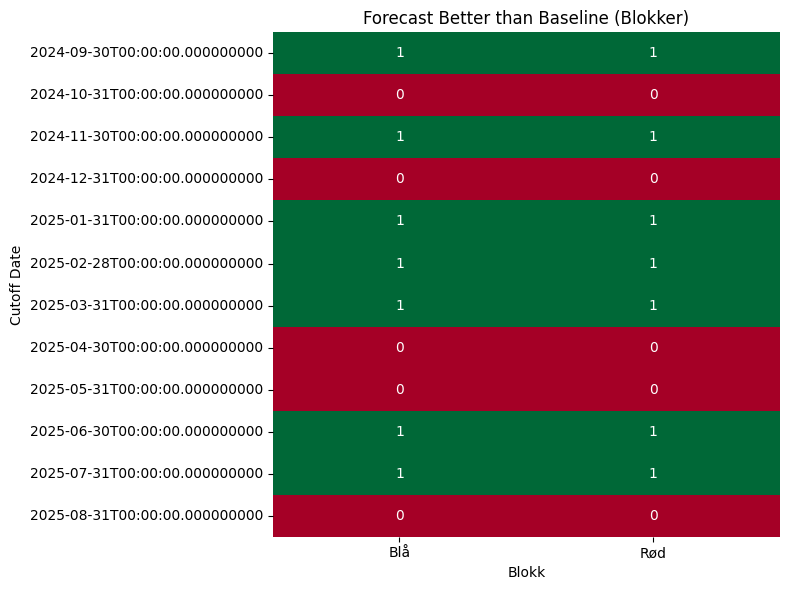

In [430]:
import seaborn as sns
import matplotlib.pyplot as plt

# bruk blokktabellen 'agg' fra forrige steg
heatmap_data_blokk = (
    agg.pivot(index="cutoff", columns="blokk", values="better_than_baseline")
    .astype(int)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_blokk,
    annot=True,
    fmt="d",
    cmap="RdYlGn",
    cbar=False
)

plt.title("Forecast Better than Baseline (Blokker)")
plt.xlabel("Blokk")
plt.ylabel("Cutoff Date")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
